In [21]:
#%pip install opendatasets
#%pip install pandas
import opendatasets as od 
import pandas as pd
od.download("https://www.kaggle.com/datasets/adilshamim8/personalized-learning-and-adaptive-education-dataset")

Skipping, found downloaded files in ".\personalized-learning-and-adaptive-education-dataset" (use force=True to force download)


In [55]:
#%pip install scikit-learn
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [26]:
the_path =  ".\personalized-learning-and-adaptive-education-dataset"
print(os.listdir(the_path))
directory = os.listdir(the_path)
data = os.path.join(the_path, directory[0])
df = pd.read_csv(data)

df

['personalized_learning_dataset.csv']


,Student_ID,Age,Gender,Education_Level,Course_Name,Time_Spent_on_Videos,Quiz_Attempts,Quiz_Scores,Forum_Participation,Assignment_Completion_Rate,Engagement_Level,Final_Exam_Score,Learning_Style,Feedback_Score,Dropout_Likelihood
0,S00001,15,Female,High School,Machine Learning,171,4,67,2,89,Medium,51,Visual,1,No
1,S00002,49,Male,Undergraduate,Python Basics,156,4,64,0,94,Medium,92,Reading/Writing,5,No
2,S00003,20,Female,Undergraduate,Python Basics,217,2,55,2,67,Medium,45,Reading/Writing,1,No
3,S00004,37,Female,Undergraduate,Data Science,489,1,65,43,60,High,59,Visual,4,No
4,S00005,34,Female,Postgraduate,Python Basics,496,3,59,34,88,Medium,93,Visual,3,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,S09996,26,Female,Undergraduate,Machine Learning,162,2,87,27,73,Medium,68,Kinesthetic,2,No
9996,S09997,37,Male,Postgraduate,Machine Learning,447,2,39,10,68,Medium,46,Reading/Writing,1,Yes
9997,S09998,40,Female,Postgraduate,Machine Learning,105,4,50,23,41,High,64,Visual,1,No
9998,S09999,44,Male,High School,Python Basics,245,2,84,39,85,Medium,38,Visual,2,No


                Age  Time_Spent_on_Videos  Quiz_Attempts   Quiz_Scores  \
count  10000.000000          10000.000000   10000.000000  10000.000000   
mean      32.137700            255.375400       2.500500     64.578600   
std       10.062647            141.656392       1.122642     20.289125   
min       15.000000             10.000000       1.000000     30.000000   
25%       24.000000            131.000000       1.000000     47.000000   
50%       32.000000            257.000000       3.000000     65.000000   
75%       41.000000            378.000000       4.000000     82.000000   
max       49.000000            499.000000       4.000000     99.000000   

       Forum_Participation  Assignment_Completion_Rate  Final_Exam_Score  \
count         10000.000000                10000.000000      10000.000000   
mean             24.616200                   69.546800         64.697000   
std              14.330305                   17.360782         20.096417   
min               0.000000   

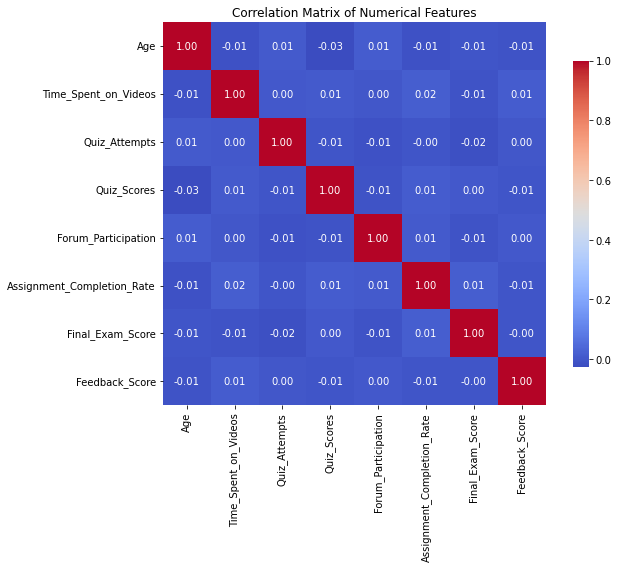

In [51]:
#cleaning data / EDA 

#check for outliers
df[df['Final_Exam_Score'] > 95]

#show stats
numeric_stats = df.describe(include = ['number'])
categorical_stats = df.describe(include= ["object"])

print(numeric_stats)
print(categorical_stats)

#show correlation; however, surprisingly not highly correlated?
corr_matrix = df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()

In [53]:
X = df.drop(columns = "Final_Exam_Score")
Y = df["Final_Exam_Score"]

#idea: create combined features to try and boost MLP model capturing
df["QuizScore_per_Attempt"] = df["Quiz_Scores"] / df["Quiz_Attempts"]
df["EngagedTime"] = df["Time_Spent_on_Videos"] * (df["Assignment_Completion_Rate"] / 100)
 

#standardize and OHC categorical variables
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)


In [56]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
my_model =  MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)


#to have data and model in one place to fit
mlp_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", my_model)
])



#defining parameter grid for tuning 
param_grid = {
    'regressor__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'regressor__activation': ['relu', 'tanh'],
    'regressor__alpha': [0.0001, 0.001],
    'regressor__learning_rate_init': [0.001, 0.01]
}


#running grid search to find best combo
grid_search = GridSearchCV(
    estimator= mlp_pipeline,  
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best RMSE score:", -grid_search.best_score_)



Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [49]:
# Train model
# mlp_pipeline.fit(X_train, y_train)

# Predict
y_pred = grid_search.predict(X_test)
# y_pred = mlp_pipeline.predict(X_test)

#metrics to evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

#of combined features and grid search implemented 
rmse, r2

In [50]:
#for my_model without any enhanced features or 
rmse, r2

(20.354169621238768, -0.0017129055479816468)